# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
from skimage.transform import resize as imresize
import datetime
import os

import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

#experiment with the batch size
#Default batch size
batch_size = 64

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
x=30
y=120
z=120

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #num_batches = # calculate the number of batches
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #Image Crop
                    if image.shape[0] != image.shape[1]:
                        temp_image = image[0:120,20:140]
                    else:
                        temp_image = image
                    
                    #Image Resize
                    temp_image = imresize(temp_image,(120,120))
                    
                    #Normalize the image
                    temp_image= temp_image/255.0
                    
                    batch_data[folder,idx,:,:,0] = temp_image[:,:,0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = temp_image[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = temp_image[:,:,2]#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #Image Crop
                    if image.shape[0] != image.shape[1]:
                        temp_image = image[0:120,20:140]
                    else:
                        temp_image = image
                    
                    #Image Resize
                    temp_image = imresize(temp_image,(120,120))
                    
                    #Normalize the image
                    temp_image= temp_image/255.0
                    
                    batch_data[folder,idx,:,:,0] = temp_image[:,:,0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = temp_image[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = temp_image[:,:,2]#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
#Default epoch
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
#function for basic datasetup and model training
def trainmodel(model,batch_size,num_epochs):
    #Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    # write the REducelronplateau code here
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

    callbacks_list = [checkpoint, LR]
    
    
    #The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    
    #Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history


# function to plot the training/validation accuracies/losses.
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [9]:
#Import Required Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

## Model Building

### Model 1

In [25]:
model1 = Sequential()

model1.add(Conv3D(16,kernel_size=(3,3,3),input_shape=([30,120,120,3]),padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(3,3,3)))

model1.add(Conv3D(32,kernel_size=(3,3,3),padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(3,3,3)))

model1.add(Conv3D(64,kernel_size=(3,3,3),padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(3,3,3)))

model1.add(Flatten())

model1.add(Dense(128,activation='relu'))
model1.add(Dense(64,activation='relu'))

model1.add(Dense(5,activation='softmax'))

In [26]:
#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam(learning_rate=0.01)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 40, 40, 32)    13856     
_________________________________________________________________
activation_4 (Activation)    (None, 10, 40, 40, 32)    0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 3, 13, 13, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 3, 13, 13, 64)    

In [28]:
#Train the model
#Batch Size = 32 , epochs=15
history_1 = trainmodel(model1,batch_size=32,num_epochs=15)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 3.0820 - categorical_accuracy: 0.1900Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2021-10-2214_28_20.022148/model-00001-3.08201-0.19005-1.61161-0.22000.h5
21/21 [==============================] - 136s 6s/step - loss: 3.0820 - categorical_accuracy: 0.1900 - val_loss: 1.6116 - val_categorical_accuracy: 0.2200
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.6107 - categorical_accuracy: 0.2050
Epoch 00002: saving model to model_init_2021-10-2214_28_20.022148/model-00002-1.61068-0.20497-1.60558-0.25000.h5
21/21 [==============================] - 88s 4s/step - loss: 1.6107 - categorical_accuracy: 0.2050 - val_loss: 1.6056 - val_categorical_accuracy: 0.2500
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.6105 - categorical_accuracy: 0.2155
Epoch 00003: savi

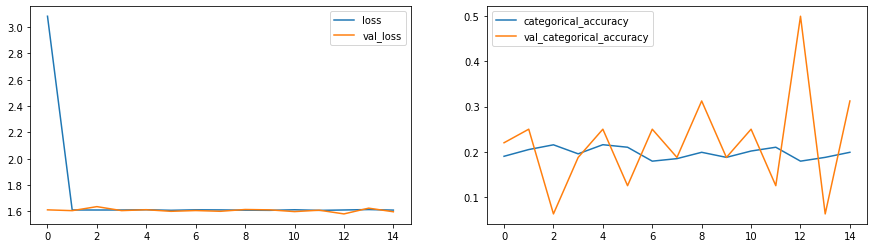

In [32]:
plot(history_1)

### Model 2

In [40]:
#Add Batch Normalization layer,and increase dence layer

model2 = Sequential()

model2.add(Conv3D(16,kernel_size=(3,3,3),input_shape=([30,120,120,3]),padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(3,3,3)))

model2.add(Conv3D(32,kernel_size=(3,3,3),padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(3,3,3)))

model2.add(Conv3D(64,kernel_size=(3,3,3),padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(3,3,3)))

model2.add(Flatten())

model2.add(Dense(128,activation='relu'))
model2.add(BatchNormalization())

model2.add(Dense(128,activation='relu'))
model2.add(BatchNormalization())

model2.add(Dense(5,activation='softmax'))

#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam(learning_rate=0.01)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_19 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 10, 40, 40, 16)    0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 10, 40, 40, 32)    13856     
_________________________________________________________________
activation_20 (Activation)   (None, 10, 40, 40, 32)    0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 40, 40, 32)   

In [41]:
#Train the model
#Batch Size = 64 , epochs=15
history_2 = trainmodel(model2,batch_size=64,num_epochs=15)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.5356 - categorical_accuracy: 0.4495 Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-10-2214_28_20.022148/model-00001-1.53564-0.44947-195.91864-0.23000.h5
11/11 [==============================] - 136s 12s/step - loss: 1.5356 - categorical_accuracy: 0.4495 - val_loss: 195.9186 - val_categorical_accuracy: 0.2300
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.0128 - categorical_accuracy: 0.5850
Epoch 00002: saving model to model_init_2021-10-2214_28_20.022148/model-00002-1.01278-0.58498-90.09054-0.14062.h5
11/11 [==============================] - 61s 6s/step - loss: 1.0128 - categorical_accuracy: 0.5850 - val_loss: 90.0905 - val_categorical_accuracy: 0.1406
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.8602 - categorical_accuracy: 0.6759
Epoch 000

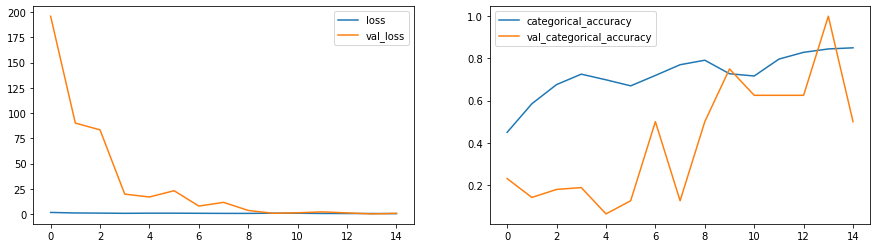

In [42]:
plot(history_2)

### Model 3

In [44]:
#Add dropout layer

model3 = Sequential()

model3.add(Conv3D(16,kernel_size=(3,3,3),input_shape=([30,120,120,3]),padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(3,3,3)))

model3.add(Conv3D(32,kernel_size=(3,3,3),padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(3,3,3)))

model3.add(Conv3D(64,kernel_size=(3,3,3),padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(3,3,3)))

model3.add(Flatten())

model3.add(Dense(128,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(128,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(5,activation='softmax'))

#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam(learning_rate=0.01)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 40, 40, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 10, 40, 40, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 40, 40, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 40, 40, 32)   

In [45]:
#Train the model
#Batch Size = 64 , epochs=15
history_3 = trainmodel(model3,batch_size=64,num_epochs=15)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 2.0591 - categorical_accuracy: 0.3062 Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-10-2214_28_20.022148/model-00001-2.05914-0.30618-313.55038-0.20000.h5
11/11 [==============================] - 135s 12s/step - loss: 2.0591 - categorical_accuracy: 0.3062 - val_loss: 313.5504 - val_categorical_accuracy: 0.2000
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.5727 - categorical_accuracy: 0.4071
Epoch 00002: saving model to model_init_2021-10-2214_28_20.022148/model-00002-1.57270-0.40711-153.67004-0.17188.h5
11/11 [==============================] - 62s 6s/step - loss: 1.5727 - categorical_accuracy: 0.4071 - val_loss: 153.6700 - val_categorical_accuracy: 0.1719
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.5471 - categorical_accuracy: 0.4032
Epoch 0

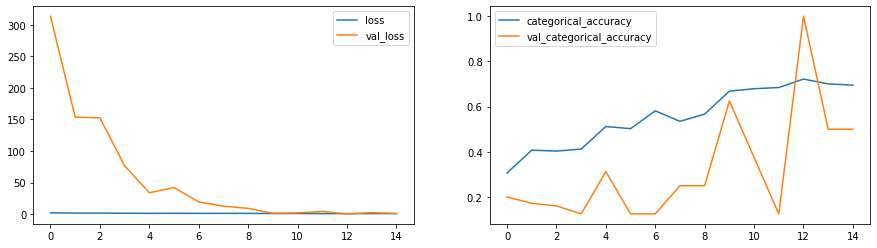

In [46]:
plot(history_3)

### Model 4

In [47]:
#Reduce MaxPooling Filter

model4 = Sequential()

model4.add(Conv3D(16,kernel_size=(3,3,3),input_shape=([30,120,120,3]),padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(32,kernel_size=(3,3,3),padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(64,kernel_size=(3,3,3),padding='same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Flatten())

model4.add(Dense(128,activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Dense(128,activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Dense(5,activation='softmax'))

#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam(learning_rate=0.01)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_29 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 15, 60, 60, 32)  

In [48]:
#Train the model
#Batch Size = 64 , epochs=20
history_4 = trainmodel(model4,batch_size=64,num_epochs=20)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 2.1868 - categorical_accuracy: 0.3077 Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-10-2214_28_20.022148/model-00001-2.18679-0.30769-151.76097-0.30000.h5
11/11 [==============================] - 136s 12s/step - loss: 2.1868 - categorical_accuracy: 0.3077 - val_loss: 151.7610 - val_categorical_accuracy: 0.3000
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.5249 - categorical_accuracy: 0.4150
Epoch 00002: saving model to model_init_2021-10-2214_28_20.022148/model-00002-1.52493-0.41502-223.02252-0.18750.h5
11/11 [==============================] - 61s 6s/step - loss: 1.5249 - categorical_accuracy: 0.4150 - val_loss: 223.0225 - val_categorical_accuracy: 0.1875
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.3115 - categorical_accuracy: 0.4980
Epoch 0

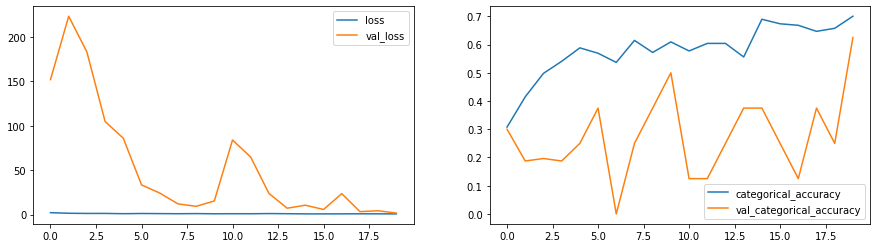

In [54]:
plot(history_4)

### Model 5

In [50]:
#Add Convulation layer with 128 feature maps

model5 = Sequential()

model5.add(Conv3D(16,kernel_size=(3,3,3),input_shape=([30,120,120,3]),padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(32,kernel_size=(3,3,3),padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(64,kernel_size=(3,3,3),padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(128,kernel_size=(3,3,3),padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Flatten())

model5.add(Dense(128,activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

model5.add(Dense(128,activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))

model5.add(Dense(5,activation='softmax'))

#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam(learning_rate=0.01)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_31 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_31 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_32 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 15, 60, 60, 32)  

In [51]:
#Train the model
#Batch Size = 64 , epochs=20
history_5 = trainmodel(model5,batch_size=64,num_epochs=20)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 2.0967 - categorical_accuracy: 0.3047 Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-10-2214_28_20.022148/model-00001-2.09668-0.30468-1689.36963-0.19000.h5
11/11 [==============================] - 143s 13s/step - loss: 2.0967 - categorical_accuracy: 0.3047 - val_loss: 1689.3696 - val_categorical_accuracy: 0.1900
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.6003 - categorical_accuracy: 0.3794
Epoch 00002: saving model to model_init_2021-10-2214_28_20.022148/model-00002-1.60028-0.37945-605.64374-0.29688.h5
11/11 [==============================] - 58s 5s/step - loss: 1.6003 - categorical_accuracy: 0.3794 - val_loss: 605.6437 - val_categorical_accuracy: 0.2969
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.3579 - categorical_accuracy: 0.4625
Epoch

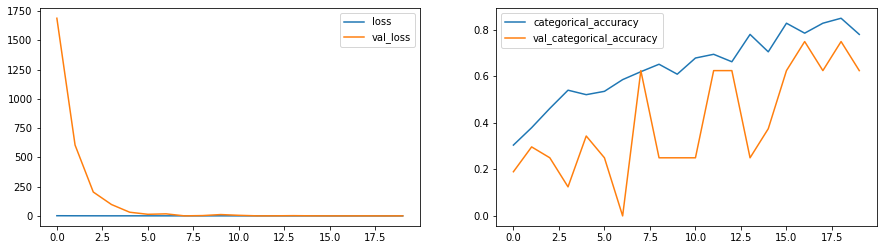

In [53]:
plot(history_5)

### Model 6

In [13]:
#Add Convulation layer with 128 feature maps

model6 = Sequential()

model6.add(Conv3D(16,kernel_size=(3,3,3),input_shape=([30,120,120,3]),padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(3,3,3)))

model6.add(Conv3D(32,kernel_size=(3,3,3),padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(3,3,3)))

model6.add(Conv3D(64,kernel_size=(3,3,3),padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(3,3,3)))

model6.add(Flatten())

model6.add(Dense(512,activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))

model6.add(Dense(128,activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))

model6.add(Dense(5,activation='softmax'))

#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam(learning_rate=0.01)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 40, 40, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 40, 40, 32)    13856     
_________________________________________________________________
activation_4 (Activation)    (None, 10, 40, 40, 32)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 40, 40, 32)   

In [14]:
#Train the model
#Batch Size = 64 , epochs=25
history_6 = trainmodel(model6,batch_size=64,num_epochs=25)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.9352 - categorical_accuracy: 0.3590 Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-10-2218_18_13.811887/model-00001-1.93524-0.35897-886.67462-0.25000.h5
11/11 [==============================] - 155s 14s/step - loss: 1.9352 - categorical_accuracy: 0.3590 - val_loss: 886.6746 - val_categorical_accuracy: 0.2500
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.3489 - categorical_accuracy: 0.4783
Epoch 00002: saving model to model_init_2021-10-2218_18_13.811887/model-00002-1.34891-0.47826-331.28442-0.31250.h5
11/11 [==============================] - 68s 6s/step - loss: 1.3489 - categorical_accuracy: 0.4783 - val_loss: 331.2844 - val_categorical_accuracy: 0.3125
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 1.4073 - categorical_accuracy: 0.4664
Epoch 0

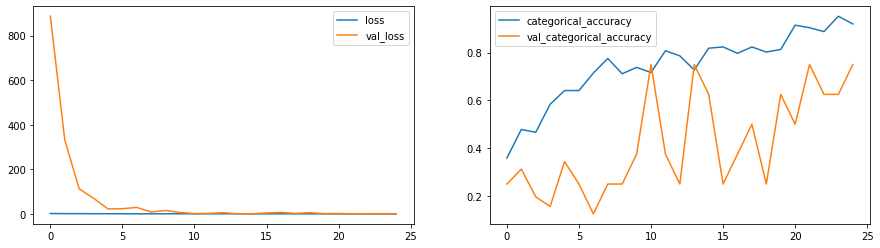

In [26]:
plot(history_6)

## CNN- RNN Architecture

In [13]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import LSTM, GRU, TimeDistributed

### Model 7

In [24]:
model7 = Sequential()

model7.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(30,120,120,3)))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
          

model7.add(TimeDistributed(Flatten()))


model7.add(LSTM(64))
model7.add(Dropout(0.25))
        
        
model7.add(Dense(5, activation='softmax'))

#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam(learning_rate=0.01)
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_34 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_35 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_36 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_39 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, 30, 30, 30, 64)   

In [25]:
#Train the model
#Batch Size = 64 , epochs=20
history_7 = trainmodel(model7,batch_size=64,num_epochs=20)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.6361 - categorical_accuracy: 0.2624 Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-10-2218_18_13.811887/model-00001-1.63614-0.26244-1.63996-0.22000.h5
11/11 [==============================] - 164s 15s/step - loss: 1.6361 - categorical_accuracy: 0.2624 - val_loss: 1.6400 - val_categorical_accuracy: 0.2200
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.5973 - categorical_accuracy: 0.2727
Epoch 00002: saving model to model_init_2021-10-2218_18_13.811887/model-00002-1.59734-0.27273-1.62990-0.25000.h5
11/11 [==============================] - 71s 6s/step - loss: 1.5973 - categorical_accuracy: 0.2727 - val_loss: 1.6299 - val_categorical_accuracy: 0.2500
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.5380 - categorical_accuracy: 0.2806
Epoch 00003: sa

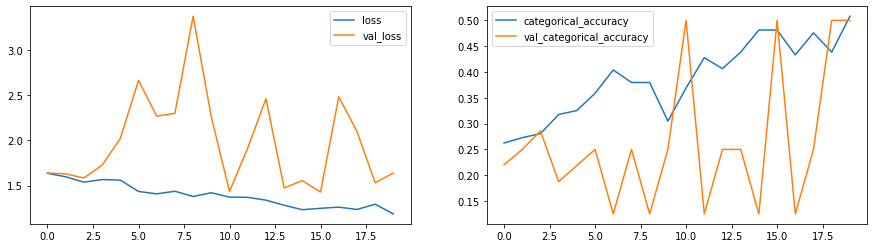

In [27]:
plot(history_7)

### Model 8

In [13]:
model8 = Sequential()

model8.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(30,120,120,3)))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3, 3))))
        
model8.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3, 3))))
        
model8.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3, 3))))
                 

model8.add(TimeDistributed(Flatten()))


model8.add(GRU(64))
model8.add(Dropout(0.5))
        
        
model8.add(Dense(5, activation='softmax'))

#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam(learning_rate=0.01)
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 40, 40, 32)    4640      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 30, 40, 40, 32)    128       
_________________________________________________________________
time_distributed_25 (TimeDis (None, 30, 13, 13, 32)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 30, 13, 13, 64)   

In [14]:
#Train the model
#Batch Size = 64 , epochs=20
history_8 = trainmodel(model8,batch_size=32,num_epochs=20)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.8804 - categorical_accuracy: 0.2564Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2021-10-2306_40_56.354351/model-00001-1.88041-0.25641-1.75964-0.18000.h5
21/21 [==============================] - 137s 7s/step - loss: 1.8804 - categorical_accuracy: 0.2564 - val_loss: 1.7596 - val_categorical_accuracy: 0.1800
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5534 - categorical_accuracy: 0.3375
Epoch 00002: saving model to model_init_2021-10-2306_40_56.354351/model-00002-1.55340-0.33747-1.87886-0.12500.h5
21/21 [==============================] - 91s 4s/step - loss: 1.5534 - categorical_accuracy: 0.3375 - val_loss: 1.8789 - val_categorical_accuracy: 0.1250
Epoch 3/20
21/21 [=============================

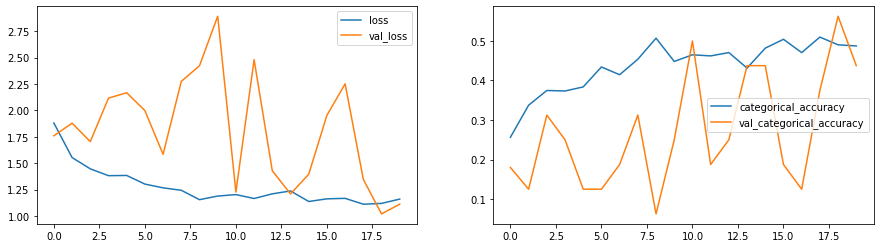

In [17]:
plot(history_8)

### Model 9

In [16]:
model9 = Sequential()

model9.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(30,120,120,3)))
model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D((3, 3))))
        
model9.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D((3, 3))))
        
model9.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D((3, 3))))
                 

model9.add(TimeDistributed(Flatten()))


model9.add(GRU(64))
model9.add(Dropout(0.5))

model9.add(Dense(128,activation='relu'))
model9.add(BatchNormalization())
model9.add(Dropout(0.5))
        
model9.add(Dense(5, activation='softmax'))

#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam(learning_rate=0.01)
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_42 (TimeDis (None, 30, 40, 40, 16)    0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 30, 40, 40, 32)    4640      
_________________________________________________________________
time_distributed_44 (TimeDis (None, 30, 40, 40, 32)    128       
_________________________________________________________________
time_distributed_45 (TimeDis (None, 30, 13, 13, 32)    0         
_________________________________________________________________
time_distributed_46 (TimeDis (None, 30, 13, 13, 64)   

In [18]:
#Train the model
#Batch Size = 32 , epochs=20
history_9 = trainmodel(model9,batch_size=32,num_epochs=20)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.3806 - categorical_accuracy: 0.2232Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2021-10-2306_40_56.354351/model-00001-2.38058-0.22323-1.63318-0.17000.h5
21/21 [==============================] - 139s 7s/step - loss: 2.3806 - categorical_accuracy: 0.2232 - val_loss: 1.6332 - val_categorical_accuracy: 0.1700
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.8960 - categorical_accuracy: 0.2215
Epoch 00002: saving model to model_init_2021-10-2306_40_56.354351/model-00002-1.89597-0.22153-1.64969-0.12500.h5
21/21 [==============================] - 90s 4s/step - loss: 1.8960 - categorical_accuracy: 0.2215 - val_loss: 1.6497 - val_categorical_accuracy: 0.1250
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.7115 - categorical_accuracy: 0.2787
Epoch 00003: savi

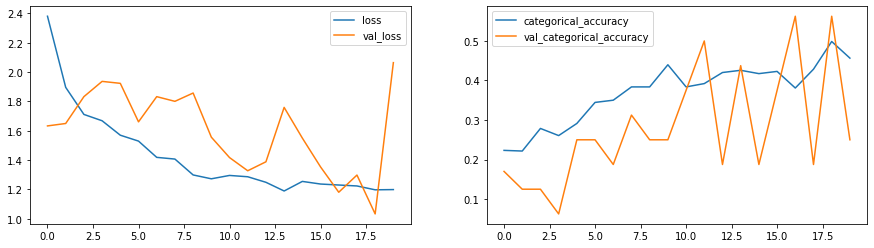

In [19]:
plot(history_9)

### Model 10

In [23]:
from tensorflow.keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

#Make weight of the transer model trainable false
mobilenet_transfer.trainable = False

In [24]:
model10 = Sequential()
model10.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,3)))
 
        
model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D((2, 2))))
model10.add(TimeDistributed(Flatten()))

model10.add(GRU(64))
model10.add(Dropout(0.25))
        
model10.add(Dense(64,activation='relu'))
model10.add(Dropout(0.25))
        
model10.add(Dense(5, activation='softmax'))
        
    
#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam()
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_50 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_51 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [25]:
#Train the model
#Batch Size = 64 , epochs=20
history_10 = trainmodel(model10,batch_size=64,num_epochs=20)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5907 - categorical_accuracy: 0.2941 Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-10-2306_40_56.354351/model-00001-1.59068-0.29412-1.32217-0.52000.h5
11/11 [==============================] - 143s 13s/step - loss: 1.5907 - categorical_accuracy: 0.2941 - val_loss: 1.3222 - val_categorical_accuracy: 0.5200
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.1352 - categorical_accuracy: 0.5652
Epoch 00002: saving model to model_init_2021-10-2306_40_56.354351/model-00002-1.13524-0.56522-1.03996-0.67188.h5
11/11 [==============================] - 61s 6s/step - loss: 1.1352 - categorical_accuracy: 0.5652 - val_loss: 1.0400 - val_categorical_accuracy: 0.6719
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.9456 - categorical_accuracy: 0.6126
Epoch 00003: sa

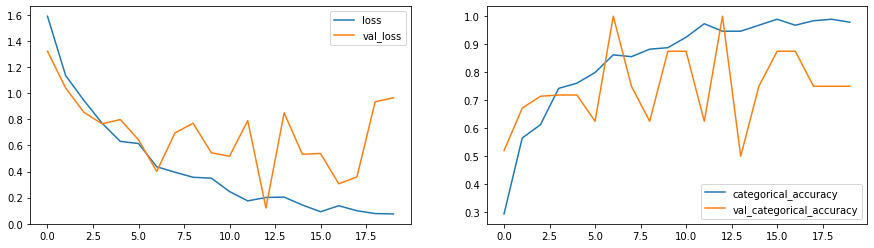

In [26]:
plot(history_10)

### Model 11

In [27]:
model11 = Sequential()
model11.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,3)))
 
        
model11.add(TimeDistributed(BatchNormalization()))
model11.add(TimeDistributed(MaxPooling2D((2, 2))))
model11.add(TimeDistributed(Flatten()))

model11.add(GRU(64))
model11.add(Dropout(0.5))
        
model11.add(Dense(64,activation='relu'))
model11.add(Dropout(0.5))
        
model11.add(Dense(5, activation='softmax'))
        
    
#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam()
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_54 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_55 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_56 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_57 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

In [29]:
#Train the model
#Batch Size = 64 , epochs=20
history_11 = trainmodel(model11,batch_size=64,num_epochs=20)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.9395 - categorical_accuracy: 0.2338 Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-10-2306_40_56.354351/model-00001-1.93949-0.23379-1.50655-0.40000.h5
11/11 [==============================] - 139s 13s/step - loss: 1.9395 - categorical_accuracy: 0.2338 - val_loss: 1.5065 - val_categorical_accuracy: 0.4000
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.5690 - categorical_accuracy: 0.3320
Epoch 00002: saving model to model_init_2021-10-2306_40_56.354351/model-00002-1.56902-0.33202-1.39148-0.42188.h5
11/11 [==============================] - 62s 6s/step - loss: 1.5690 - categorical_accuracy: 0.3320 - val_loss: 1.3915 - val_categorical_accuracy: 0.4219
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.4319 - categorical_accuracy: 0.3320
Epoch 00003: sa

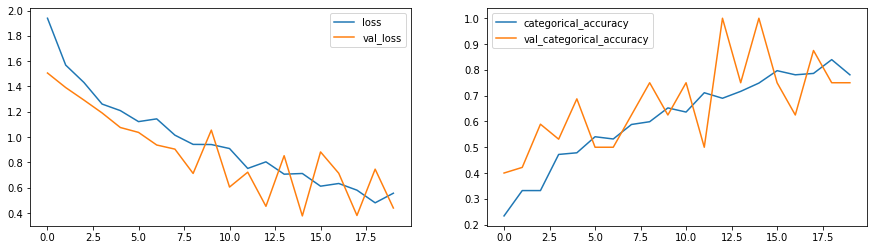

In [30]:
plot(history_11)

### Model 12

In [15]:
from tensorflow.keras.applications import ResNet50

restnet_transfer = ResNet50(weights='imagenet', include_top=False,pooling='max')

#Make weight of the transer model trainable false
restnet_transfer.trainable = False


In [25]:
model12 = Sequential()
model12.add(TimeDistributed(restnet_transfer,input_shape=(30,120,120,3)))

model12.add(GRU(64))
model12.add(Dropout(0.5))

model12.add(Dense(5, activation='softmax'))
        
    
#`compile` the model.`summary` of the model,tell the total number of parameters
optimiser = optimizers.Adam()
model12.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model12.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 30, 2048)          23587712  
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                405888    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 23,993,925
Trainable params: 406,213
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [26]:
#Train the model
#Batch Size = 64 , epochs=20
history_12 = trainmodel(model12,batch_size=64,num_epochs=20)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.9856 - categorical_accuracy: 0.1991Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2021-10-2311_46_30.754481/model-00001-1.98556-0.19910-1.65828-0.20000.h5
11/11 [==============================] - 128s 12s/step - loss: 1.9856 - categorical_accuracy: 0.1991 - val_loss: 1.6583 - val_categorical_accuracy: 0.2000
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.7909 - categorical_accuracy: 0.2451
Epoch 00002: saving model to model_init_2021-10-2311_46_30.754481/model-00002-1.79087-0.24506-1.53692-0.21875.h5
11/11 [==============================] - 59s 5s/step - loss: 1.7909 - categorical_accuracy: 0.2451 - val_loss: 1.5369 - val_categorical_accuracy: 0.2188
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.6356 - categorical_accuracy: 0.3202
Epoch 00003: sav

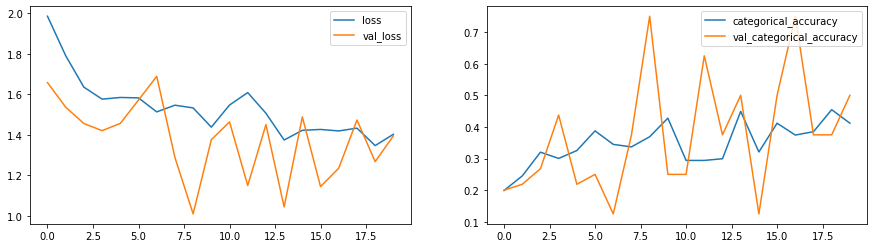

In [27]:
plot(history_12)

In [ ]:
from tensorflow.keras.applications import VGG19